In [23]:
!pip install tf-keras


   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
    --------------------------------------- 0.0/1.7 MB 487.6 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/1.7 MB 819.2 kB/s eta 0:00:02
   ----- ---------------------------------- 0.3/1.7 MB 1.6 MB/s eta 0:00:01
   -------------- ------------------------- 0.6/1.7 MB 2.8 MB/s eta 0:00:01
   -------------------------- ------------- 1.1/1.7 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------  1.7/1.7 MB 5.8 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 5.5 MB/s eta 0:00:00


In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import pandas as pd
import numpy as np
import transformers
from tensorflow import keras
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
df = pd.read_csv("data/IMDB_Dataset.csv")
# change sentiment to 0 or 1 for negative or positive, respectively 
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
dataset = Dataset.from_pandas(df)

In [8]:
# load pre-trained distilbert and tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load model and tokenizer
model_name = "distilbert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [9]:
# tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples["review"], padding="max_length", truncation=True, return_tensors="pt", max_length=512)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [10]:
# split data 80/20
train_dataset = tokenized_dataset.shuffle(seed=42).select([i for i in range(int(0.8 * len(tokenized_dataset)))])
test_dataset = tokenized_dataset.shuffle(seed=42).select([i for i in range(int(0.8 * len(tokenized_dataset)), len(tokenized_dataset))])
# rename sentiment column to label
train_dataset = train_dataset.rename_column("sentiment", "label")
test_dataset = test_dataset.rename_column("sentiment", "label")

In [16]:
# import a data collator
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='pt')

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns

def compute_metrics(p):
    predictions, labels = p
    preds = predictions.argmax(axis=-1)  # Convert logits to predicted class (argmax)

    # Calculate accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


c:\Users\tyler\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\tyler\AppData\Local\Temp\ipykernel_8764\3495901727.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/5000 [00:00<?, ?it/s]

{'loss': 0.311, 'grad_norm': 4.856632232666016, 'learning_rate': 1.8e-05, 'epoch': 0.2}
{'loss': 0.2454, 'grad_norm': 4.558544158935547, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.4}
{'loss': 0.229, 'grad_norm': 7.817626953125, 'learning_rate': 1.4e-05, 'epoch': 0.6}
{'loss': 0.2089, 'grad_norm': 7.765542030334473, 'learning_rate': 1.2e-05, 'epoch': 0.8}
{'loss': 0.2072, 'grad_norm': 14.882862091064453, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/625 [00:00<?, ?it/s]

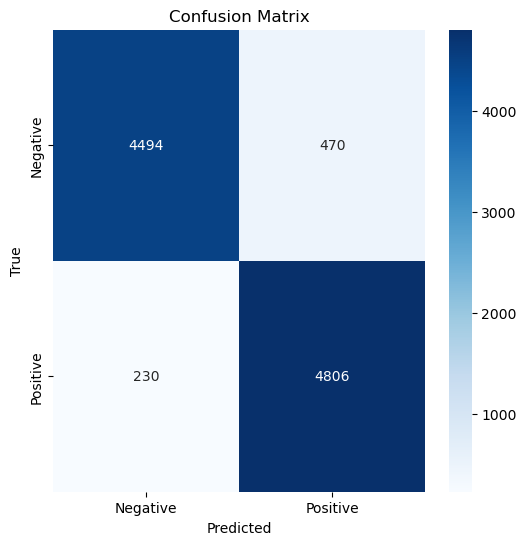

{'eval_loss': 0.18603776395320892, 'eval_accuracy': 0.93, 'eval_precision': 0.9109173616376043, 'eval_recall': 0.954328832406672, 'eval_f1': 0.9321179208688906, 'eval_runtime': 77.6917, 'eval_samples_per_second': 128.714, 'eval_steps_per_second': 8.045, 'epoch': 1.0}
{'loss': 0.1381, 'grad_norm': 19.53644371032715, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.2}
{'loss': 0.1315, 'grad_norm': 11.844305992126465, 'learning_rate': 6e-06, 'epoch': 1.4}
{'loss': 0.136, 'grad_norm': 10.375853538513184, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.6}
{'loss': 0.1315, 'grad_norm': 13.01870346069336, 'learning_rate': 2.0000000000000003e-06, 'epoch': 1.8}
{'loss': 0.1301, 'grad_norm': 0.14522957801818848, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/625 [00:00<?, ?it/s]

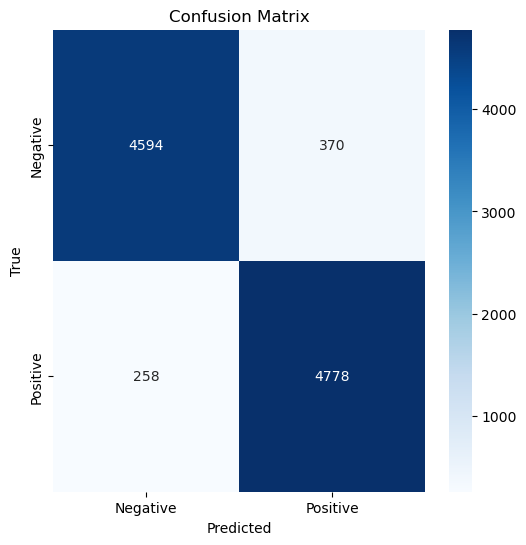

{'eval_loss': 0.21907509863376617, 'eval_accuracy': 0.9372, 'eval_precision': 0.9281274281274281, 'eval_recall': 0.948768864177919, 'eval_f1': 0.9383346425765907, 'eval_runtime': 77.6425, 'eval_samples_per_second': 128.795, 'eval_steps_per_second': 8.05, 'epoch': 2.0}
{'train_runtime': 2342.3955, 'train_samples_per_second': 34.153, 'train_steps_per_second': 2.135, 'train_loss': 0.18686834106445313, 'epoch': 2.0}


  0%|          | 0/625 [00:00<?, ?it/s]

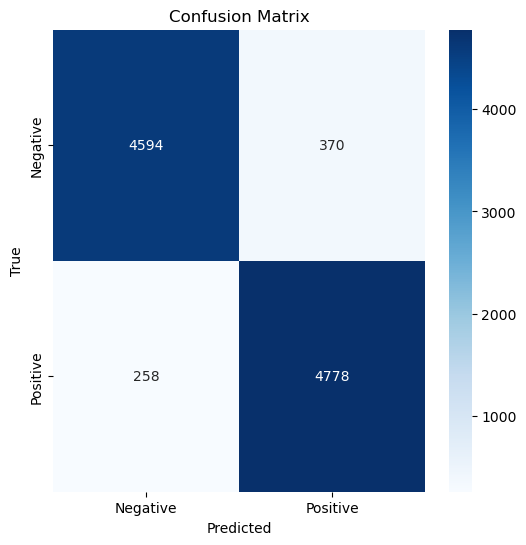

{'eval_loss': 0.21907509863376617, 'eval_accuracy': 0.9372, 'eval_precision': 0.9281274281274281, 'eval_recall': 0.948768864177919, 'eval_f1': 0.9383346425765907, 'eval_runtime': 77.8697, 'eval_samples_per_second': 128.42, 'eval_steps_per_second': 8.026, 'epoch': 2.0}


In [17]:
from transformers import TrainingArguments, Trainer
# training model on data
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    evaluation_strategy="epoch",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()
trainer.save_model('./fine_tuned_distilbert')
results = trainer.evaluate()
print(results)

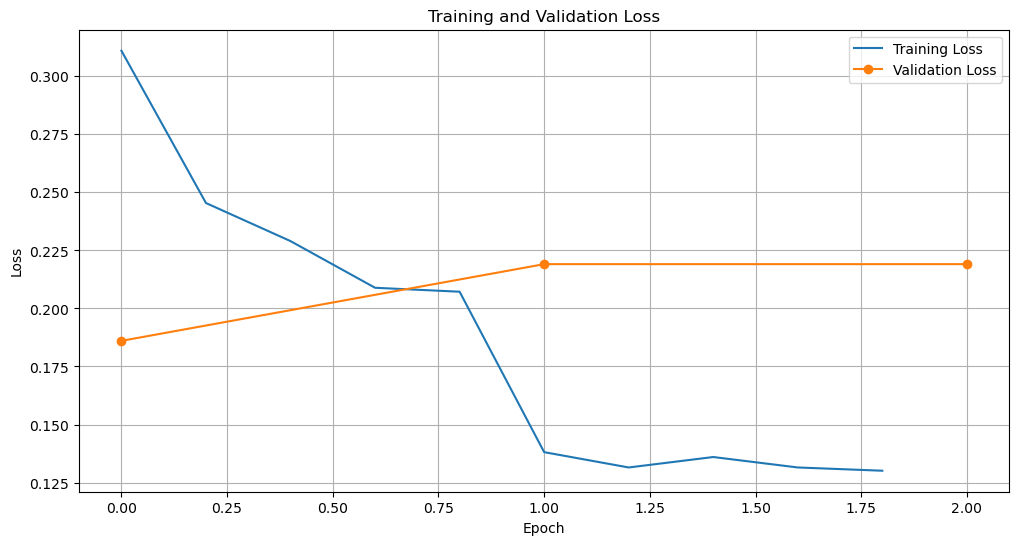

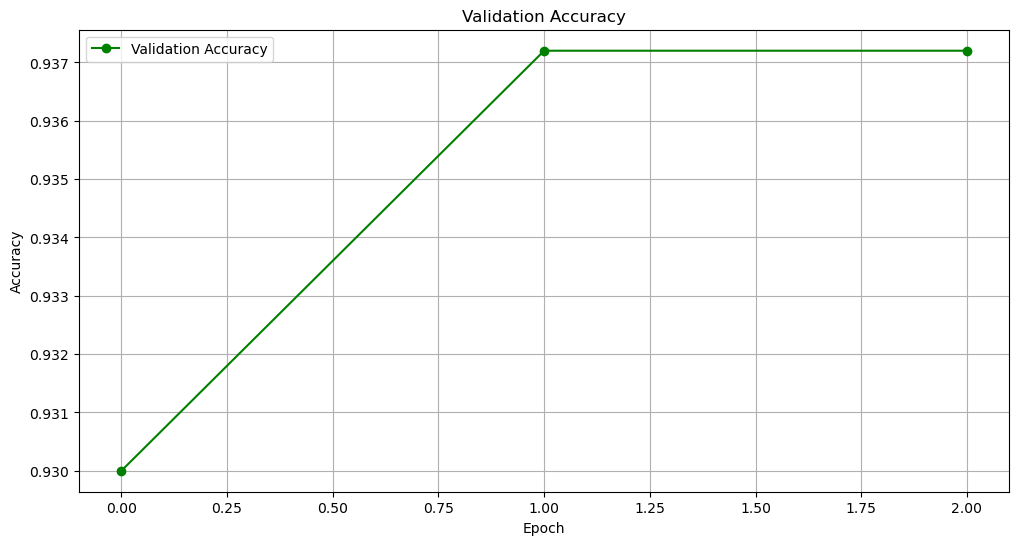

In [18]:
training_logs = trainer.state.log_history
import matplotlib.pyplot as plt

# Extract loss and accuracy logs
train_loss = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]
accuracy = [log["eval_accuracy"] for log in training_logs if "eval_accuracy" in log]

train_epochs = [i * 0.2 for i in range(len(train_loss))]

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_epochs, train_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(accuracy, label="Validation Accuracy", marker="o", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/625 [00:00<?, ?it/s]

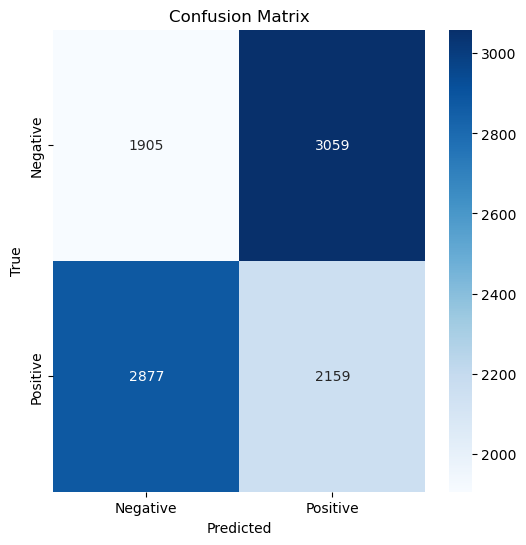

{'eval_loss': 0.6968477368354797, 'eval_model_preparation_time': 0.001, 'eval_accuracy': 0.4064, 'eval_precision': 0.4137600613261786, 'eval_recall': 0.42871326449563146, 'eval_f1': 0.42110395943046613, 'eval_runtime': 86.3919, 'eval_samples_per_second': 115.752, 'eval_steps_per_second': 7.234}


In [19]:
# load some packages again so i dont have to redo the whole fine tuned one
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
# load base model
model_name = "distilbert-base-uncased" 
base_model = AutoModelForSequenceClassification.from_pretrained(model_name)

#  not actually training model, just evaluating it
training_args = TrainingArguments(
    output_dir='./base_results',            
    per_device_eval_batch_size=16,     
    no_cuda=False,                     
)
trainer = Trainer(
    model=base_model,                  
    args=training_args,               
    eval_dataset=test_dataset,         
    compute_metrics=compute_metrics     
)

# Evaluate the model
results = trainer.evaluate()

# Print the results
print(results)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
# split original data again (untokenized) for RF model
train, test= train_test_split(df, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']

# TF-IDF vectorizer
tfidf_vect = TfidfVectorizer() 
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vect.transform(Xtest)

Precision: 0.8543
Recall: 0.8377
F1-Score: 0.8459
Random Forest Accuracy : 84.62%


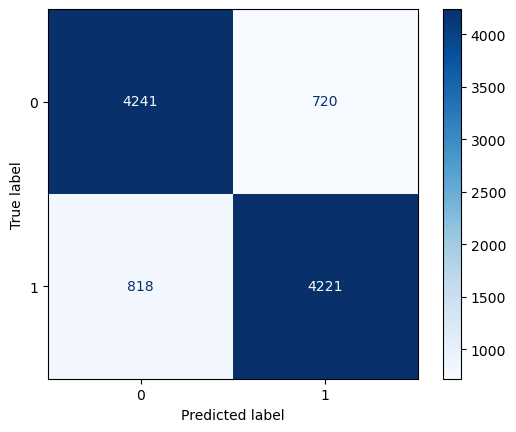

In [26]:
# implement Random Forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(Xtrain_tfidf, ytrain)

# predict based on training data
rf_pred = rf_model.predict(Xtest_tfidf)

precision, recall, f1, _ = precision_recall_fscore_support(ytest, rf_pred, average='binary')
# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

score = accuracy_score(ytest, rf_pred)
print("Random Forest Accuracy :", "{:.2f}%".format(100 * score))

disp = ConfusionMatrixDisplay.from_estimator(rf_model, Xtest_tfidf, ytest, cmap='Blues')
plt.grid(False)
plt.show()